# Import

In [ ]:
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline

# Data Exploratory

In [ ]:
now = str(int(datetime.now().timestamp()))
start = '1483200000'
crypto_pair = 'USDT_BTC'
res = requests.get('https://poloniex.com/public?command=returnChartData&currencyPair=' 
                   + crypto_pair + '&start=' + start + '&end=' + now + '&period=14400')
df = pd.DataFrame(res.json())

In [ ]:
df['date'] = pd.to_datetime(df['date'], unit = 's')
df.columns = [df.columns[0]] + ['BTC_' + i for i in df.columns[1:]]

In [ ]:
df.head()

,date,BTC_high,BTC_low,BTC_open,BTC_close,BTC_volume,BTC_quoteVolume,BTC_weightedAverage
0,2016-12-31 16:00:00,967.5100,956.000000,956.000000,959.000000,61734.313739,64.081354,963.374055
1,2016-12-31 20:00:00,966.6150,956.675981,960.000000,966.173684,26851.868348,27.912374,962.005886
2,2017-01-01 00:00:00,968.0000,957.020000,965.000001,960.543195,66617.446798,69.167350,963.134298
3,2017-01-01 04:00:00,967.9999,960.192267,960.977614,967.800000,59615.947687,61.801571,964.634829
4,2017-01-01 08:00:00,976.3010,962.720039,967.000000,974.510008,104792.585699,108.074608,969.631882


In [ ]:
df.tail()

,date,BTC_high,BTC_low,BTC_open,BTC_close,BTC_volume,BTC_quoteVolume,BTC_weightedAverage
8922,2021-01-26 16:00:00,32382.276240,31320.000000,31750.127794,32205.419393,5.745211e+06,179.652788,31979.528626
8923,2021-01-26 20:00:00,32885.000000,31853.386547,32203.121440,32490.948488,3.215972e+06,99.594170,32290.763287
8924,2021-01-27 00:00:00,32550.242953,31582.000000,32486.922604,31806.235845,9.106259e+06,284.020763,32061.949625
8925,2021-01-27 04:00:00,32007.961294,31362.369832,31772.788879,31776.000000,9.355290e+06,295.564879,31652.238944
8926,2021-01-27 08:00:00,31753.667939,30953.860000,31750.461431,30953.860000,4.356748e+06,139.120010,31316.472025


In [ ]:
df.set_index("date" , inplace=True)

In [ ]:
df.head()

,BTC_high,BTC_low,BTC_open,BTC_close,BTC_volume,BTC_quoteVolume,BTC_weightedAverage
date,,,,,,,
2016-12-31 16:00:00,967.5100,956.000000,956.000000,959.000000,61734.313739,64.081354,963.374055
2016-12-31 20:00:00,966.6150,956.675981,960.000000,966.173684,26851.868348,27.912374,962.005886
2017-01-01 00:00:00,968.0000,957.020000,965.000001,960.543195,66617.446798,69.167350,963.134298
2017-01-01 04:00:00,967.9999,960.192267,960.977614,967.800000,59615.947687,61.801571,964.634829
2017-01-01 08:00:00,976.3010,962.720039,967.000000,974.510008,104792.585699,108.074608,969.631882


In [ ]:
df = df[["BTC_open"]]

In [ ]:
df.shape

(8927, 1)

Text(0.5, 1.0, 'Price of Bitcoin')

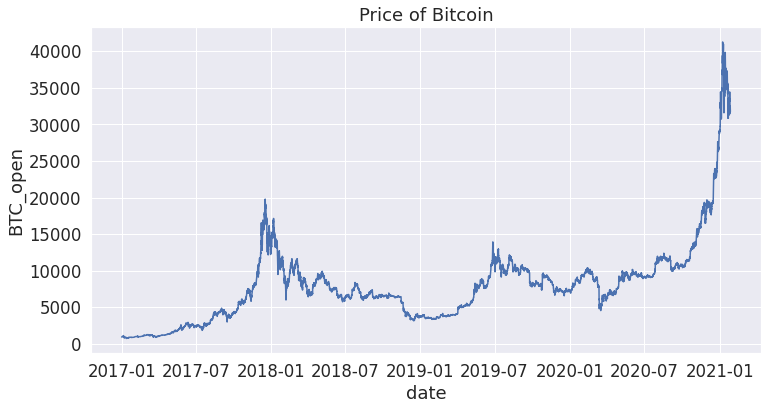

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="BTC_open", data=df).set_title("Price of Bitcoin")

Text(0.5, 0.9, 'Down-sampled to 10-day periods')

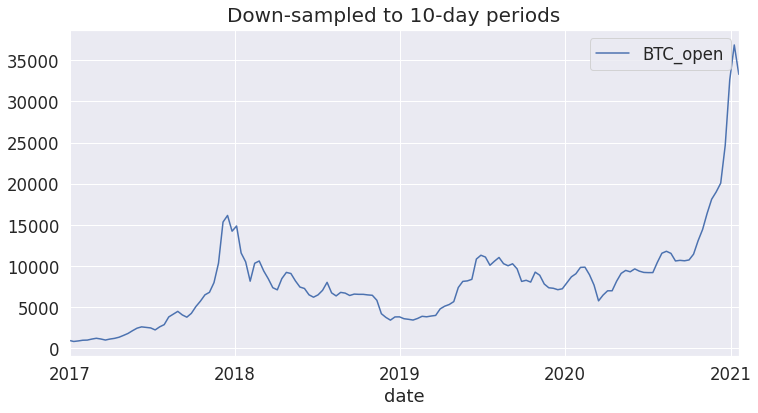

In [ ]:
df.resample('10D').mean().plot(figsize=(12,6))
plt.figtext(.5,0.9,"Down-sampled to 10-day periods", fontsize=20, ha='center')

# Data Preprocessing

In [ ]:
data = df.iloc[:, 0]
hist = []
target = []
length = 90
for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [ ]:
print(hist[1][89])
print(data[90])
print(target[0])

813.97999594
813.97999594
813.97999594


In [ ]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [ ]:
hist.shape

(8837, 90)

In [ ]:
target.shape

(8837, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [ ]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(8837, 90, 1)


# Training & Testing Split

In [ ]:
X_train = hist_scaled[:7000,:,:]
X_test = hist_scaled[7000:,:,:]
y_train = target_scaled[:7000,:]
y_test = target_scaled[7000:,:]

In [ ]:
X_train.shape

(7000, 90, 1)

In [ ]:
X_test.shape

(1837, 90, 1)

In [ ]:
y_train.shape

(7000, 1)

In [ ]:
y_test.shape

(1837, 1)

# Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
219/219 [==============================] - 27s 99ms/step - loss: 0.0021
Epoch 2/30
219/219 [==============================] - 22s 101ms/step - loss: 3.9413e-04
Epoch 3/30
219/219 [==============================] - 22s 99ms/step - loss: 4.0026e-04
Epoch 4/30
219/219 [==============================] - 22s 98ms/step - loss: 3.7297e-04
Epoch 5/30
219/219 [==============================] - 22s 98ms/step - loss: 3.6623e-04
Epoch 6/30
219/219 [==============================] - 21s 98ms/step - loss: 3.7475e-04
Epoch 7/30
219/219 [==============================] - 22s 100ms/step - loss: 3.6051e-04
Epoch 8/30
219/219 [==============================] - 21s 98ms/step - loss: 3.3198e-04
Epoch 9/30
219/219 [==============================] - 22s 100ms/step - loss: 3.3240e-04
Epoch 10/30
219/219 [==============================] - 21s 98ms/step - loss: 3.2295e-04
Epoch 11/30
219/219 [==============================] - 21s 98ms/step - loss: 3.1597e-04
Epoch 12/30
219/219 [=====================

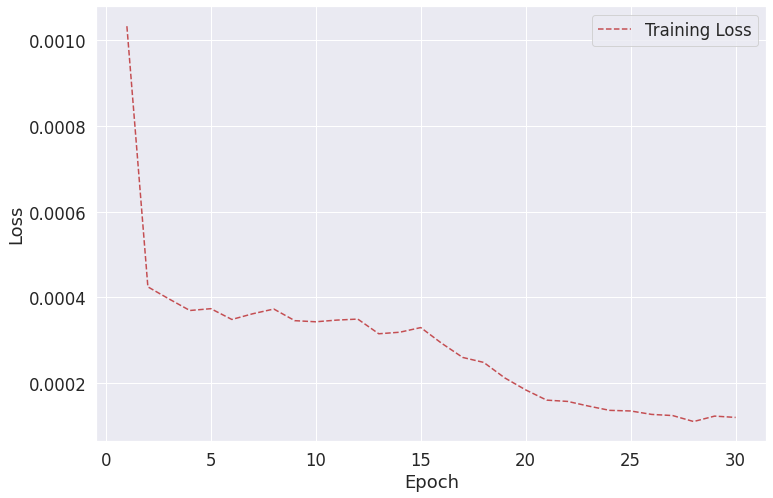

In [ ]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

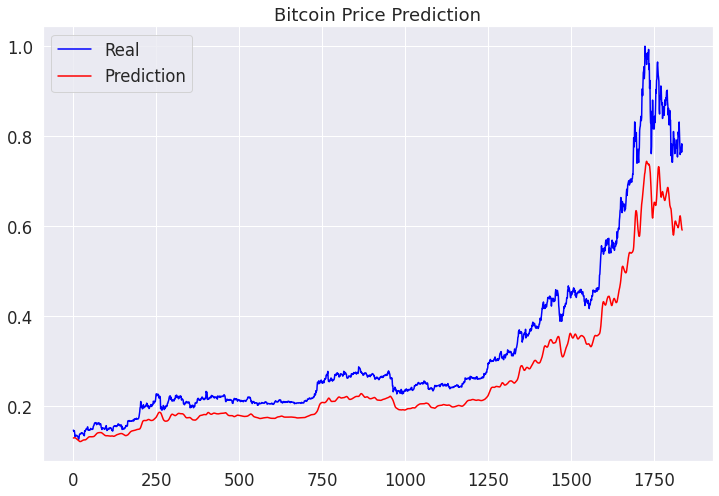

In [ ]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

In [ ]:
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)

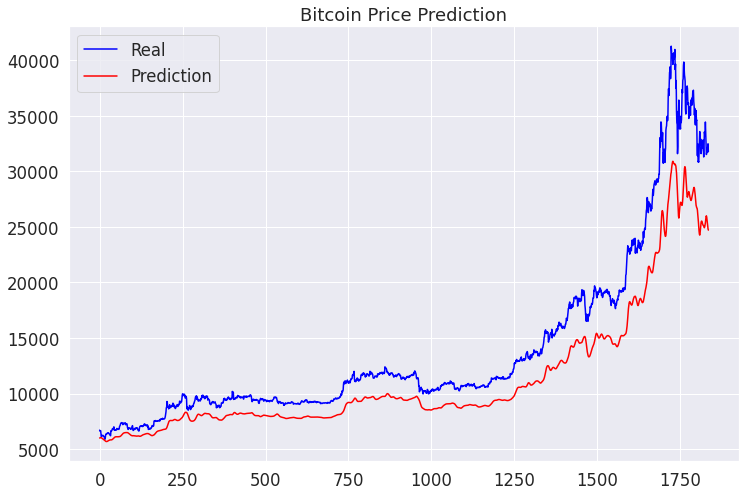

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()